# Full PolyA Prediction Pipeline

## Import

In [1]:
import os, csv, ast, subprocess
from pathlib import Path
import pickle
import pyfaidx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
from matplotlib.ticker import MultipleLocator

In [2]:
PROJECT   = os.path.abspath(os.path.join(".",""))
RESOURCES = os.path.join(PROJECT, "resources")
RESULTS   = os.path.join(PROJECT, "results")
OUTDIR = RESULTS
os.makedirs(OUTDIR, exist_ok=True)
MODEL_PATHS = {
  "polyaid":       Path("resources/published_models/PolyaID.h5"),
  "polyastrength": Path("resources/published_models/PolyaStrength.h5")
}
CODE_DIR = Path("code")
OUTDIR   = Path("results")
OUTDIR.mkdir(exist_ok=True, parents=True)

## Helper Function

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## MODEL PARAMETERS

input_shape               = (240,4)

polyaid_bin_len           = 1
polyaid_bin_dropout       = 0.7
polyaid_vec_len           = 50
polyaid_vec_dropout       = 0.1

polyastrength_bin_len     = 1
polyastrength_bin_dropout = 0.1

def make_polyaid_model(model_path):
	'''Builds the PolyaID model and loads the trained weights.
	'''

	from contextlib import redirect_stderr

	with redirect_stderr(open(os.devnull, "w")):

		from keras import Input
		from keras.models import Model
		from keras.layers import Dense, Dropout, Flatten, Bidirectional
		from keras.layers import Conv1D, MaxPooling1D, LSTM
		from keras.activations import sigmoid
		from keras.layers import ReLU
		from keras import backend as K

	import tensorflow as tf
	tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
	
	model_input = Input(shape = input_shape)
	
	x = ReLU()(Conv1D(512, 8, padding = 'valid', strides = 1, name = 'bin_conv')(model_input))
	x = MaxPooling1D(pool_size = 3, strides = 3, name = 'bin_pool')(x)
	x = Dropout(polyaid_bin_dropout)(x)
	x = Bidirectional(LSTM(units = 128, return_sequences = True, name = 'bin_lstm'))(x)
	x = Dropout(polyaid_bin_dropout)(x)
	x = Flatten(name = 'bin_flatten')(x)
		
	bin_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'bin_dense1')(x))
	bin_x = Dropout(polyaid_bin_dropout)(bin_x)
	bin_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'bin_dense2')(bin_x))
	bin_x = Dropout(polyaid_bin_dropout)(bin_x)
	bin_x = ReLU()(Dense(128, kernel_initializer = 'glorot_uniform', name = 'bin_dense3')(bin_x))
	bin_x = Dropout(polyaid_bin_dropout)(bin_x)
	bin_x = ReLU()(Dense(64, name = 'bin_dense4')(bin_x))
	bin_x = Dense(polyaid_bin_len, activation = 'sigmoid', name = 'bin_predictions')(bin_x)
		
	prob_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'prob_dense1')(x))
	prob_x = Dropout(polyaid_vec_dropout)(prob_x)
	prob_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'prob_dense2')(prob_x))
	prob_x = Dropout(polyaid_vec_dropout)(prob_x)
	prob_x = ReLU()(Dense(128, kernel_initializer = 'glorot_uniform', name = 'prob_dense3')(prob_x))
	prob_x = Dropout(polyaid_vec_dropout)(prob_x)
	prob_x = ReLU()(Dense(64, name = 'prob_dense4')(prob_x))
	prob_x = Dense(polyaid_vec_len, activation = 'softmax', kernel_initializer = 'zeros', name = 'prob_predictions')(prob_x)
	
	model = Model(inputs = [model_input], outputs = [bin_x, prob_x], name = 'model')
	model.load_weights(model_path)
		
	return model



def make_polyastrength_model(model_path):
	'''Builds the PolyaStrength model and loads the trained weights.
	'''

	from contextlib import redirect_stderr

	with redirect_stderr(open(os.devnull, "w")):

		from keras import Input
		from keras.models import Model
		from keras.layers import Dense, Dropout, Flatten, Bidirectional
		from keras.layers import Conv1D, MaxPooling1D, LSTM
		from keras.layers import ReLU	
		from keras import backend as K

	import tensorflow as tf
	tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

	model_input = Input(shape = input_shape)

	x = ReLU()(Conv1D(64, 8, padding = 'valid', strides = 1, name = 'seq_conv')(model_input))
	x = MaxPooling1D(pool_size = 3, strides = 3, name = 'bin_pool')(x)
	x = Dropout(polyastrength_bin_dropout)(x)
	x = Bidirectional(LSTM(units = 16, return_sequences = True, name = 'bin_lstm'))(x)
	x = Dropout(polyastrength_bin_dropout)(x)
	x = Flatten(name = 'bin_flatten')(x)
	
	bin_x = ReLU()(Dense(128, kernel_initializer = 'glorot_uniform', name = 'bin_dense1')(x))
	bin_x = Dropout(polyastrength_bin_dropout)(bin_x)
	bin_x = ReLU()(Dense(64, name = 'bin_dense2')(bin_x))
	bin_x = Dense(polyastrength_bin_len, activation = 'linear', name = 'bin_predictions')(bin_x)
	
	model = Model(inputs = model_input, outputs = bin_x, name = 'model')
	model.load_weights(model_path)
	
	return model

def generate_data(sequences):
	'''Prepares data generator to flow data into the models for prediction.
	'''

	import numpy as np
	import pandas as pd
	import isolearn.keras as iso

	if (isinstance(sequences, str)):
		sequences = [sequences]

	df = pd.DataFrame.from_dict({'Sequence' : sequences})
	data_idx = np.arange(len(df), dtype = int)
	
	allSequenceGenerator = {
			gen_id : iso.DataGenerator(
				idx,
				{
					'df' : df
				},
				batch_size = len(idx),
				inputs = [
					{
						'id'          : 'seq',
						'source_type' : 'dataframe',
						'source'      : 'df',
						'extractor'   : lambda row,index: row['Sequence'].upper(),
						'encoder'     : iso.OneHotEncoder(seq_length = input_shape[0]),
						'dim'         : input_shape,
						'sparsify'    : False,
					},
				],
				randomizers = [],
				shuffle = False,
				densify_batch_matrices = True,
				move_outputs_to_inputs = False
			)
			for gen_id, idx in [('predict', data_idx)]
		}
	return allSequenceGenerator

def save_sliding_windows(sequence, output_path):
	'''Save sliding windows with fixed chrom, start=0, end=0, strand=+, and 240nt sequence per row.'''

	chrom = "chrom"
	strand = "+"
	start = 0
	end = 0

	with open(output_path, 'w') as f:
		f.write("chrom\tstart\tend\tstrand\tsequence\n")
		for i in range(len(sequence) - 240 + 1):
			window_seq = sequence[i:i+240]
			f.write(f"{chrom}\t{start}\t{end}\t{strand}\t{window_seq}\n")

In [4]:
#If you use Mac OS or Linux run this cell
def run_predictions2(windows_txt: Path, outdir: Path, codedir: Path, model_paths: dict):
    merged = outdir / "comprehensive_predictions.txt"
    # run each model
    for mtype, mpath in model_paths.items():
        print(f"[Predict] {mtype} …")
        proc = subprocess.run([
            "python3", str(codedir/"example.prediction.py"),
            "--model",      str(mpath),
            "--modeltype",  mtype,
            "--data",       str(windows_txt),
            "--dataname",   "seq",
            "--outdir",     str(outdir)
        ], capture_output=True, text=True)
        print(proc.stdout, proc.stderr, sep="\n")
        proc.check_returncode()
    # merge
    p1 = outdir/"seq.predictions_polyaid.txt"
    p2 = outdir/"seq.predictions_polyastrength.txt"
    with open(merged, "w") as out, open(p1) as a, open(p2) as b:
        h1 = a.readline().rstrip().split("\t")
        h2 = b.readline().rstrip().split("\t")
        out.write("\t".join(h1[:9] + h2[-2:]) + "\n")
        for l1, l2 in zip(a, b):
            c1, c2 = l1.rstrip().split("\t"), l2.rstrip().split("\t")
            out.write("\t".join(c1[:9] + c2[-2:]) + "\n")
    return merged

In [5]:
#If you use Windows run this cell
def run_predictions2(windows_txt: Path, outdir: Path, codedir: Path, model_paths: dict):
    merged = outdir / "comprehensive_predictions.txt"
    # run each model
    for mtype, mpath in model_paths.items():
        print(f"[Predict] {mtype} …")
        proc = subprocess.run([
            "python", str(codedir/"example.prediction.py"),
            "--model",      str(mpath),
            "--modeltype",  mtype,
            "--data",       str(windows_txt),
            "--dataname",   "seq",
            "--outdir",     str(outdir)
        ], capture_output=True, text=True)
        print(proc.stdout, proc.stderr, sep="\n")
        proc.check_returncode()
    # merge
    p1 = outdir/"seq.predictions_polyaid.txt"
    p2 = outdir/"seq.predictions_polyastrength.txt"
    with open(merged, "w") as out, open(p1) as a, open(p2) as b:
        h1 = a.readline().rstrip().split("\t")
        h2 = b.readline().rstrip().split("\t")
        out.write("\t".join(h1[:9] + h2[-2:]) + "\n")
        for l1, l2 in zip(a, b):
            c1, c2 = l1.rstrip().split("\t"), l2.rstrip().split("\t")
            out.write("\t".join(c1[:9] + c2[-2:]) + "\n")
    return merged

In [8]:
def cleavage_profile_explanation2(
    ax, region, inputs, reads_dict, genome,
    visible_region=None, visible_labels=None,
    cutoff_class=0.5, cutoff_clv=0.05, background=0.02, normalize=False,
    ylims_3reads=None, ylims_clv=None, ylims_pro=None
):
    import numpy as np
    from matplotlib.ticker import MultipleLocator

    sequences, encodings, classprobs, cleavage_vecs, cleavage_ctrs, idx = inputs

    n = len(classprobs)
    if visible_region is None:
        visible_region = (region['start'], region['start'] + n)

    xs   = np.arange(region['start'], region['start'] + n, 1)
    idxs = np.arange(n)

    subset_mask = (xs >= visible_region[0]) & (xs < visible_region[1])
    subset_idxs = idxs[subset_mask]
    subset_xs   = xs[subset_mask]

    #reads = np.asarray([reads_dict.get((region['strand'], region['chrom'], x), 0) for x in xs])
    #ax[0].bar(subset_xs, reads[subset_idxs], width=2, color='gray')
    #if ylims_3reads is not None:
    #    ax[0].yaxis.set_major_locator(MultipleLocator(ylims_3reads[1]))
    #    ax[0].set_ylim(ylims_3reads)

    class_idx, class_clv_idx, cleavage_cols = [], [], []
    for i, x in zip(subset_idxs, subset_xs):
        if classprobs[i] > cutoff_class:
            class_idx.append(i)
            if cleavage_ctrs[i] > cutoff_clv:
                p = ax[1].plot(np.arange(x-25, x+25, 1), cleavage_vecs[i],
                               linewidth=0.5, alpha=0.50, zorder=2)
                cleavage_cols.append(p[-1].get_color())
                class_clv_idx.append(i)
            else:
                ax[1].plot(np.arange(x-25, x+25, 1), cleavage_vecs[i],
                           linewidth=0.25, alpha=0.05, color='gray', zorder=1)

    class_idx     = np.asarray(class_idx)
    class_clv_idx = np.asarray(class_clv_idx)
    cleavage_cols = np.asarray(cleavage_cols)

    adj_classprobs = np.asarray(classprobs) - 0.75 #this is a hardcoded value to visualize predictions 
    colormat = np.where(adj_classprobs < 0, 'C0', 'C3')
    ax[0].bar(subset_xs, adj_classprobs[subset_idxs], width=1, color=colormat[subset_idxs])
    ax[0].axhline(y=0, color='black', linestyle='dashed', linewidth=0.5)
    ax[0].set_ylim((-0.8, 0.3))
    ax[0].set_yticks([-0.75, 0.25])
    ax[0].set_yticklabels([0, 1.0])
    ax[0].yaxis.set_minor_locator(MultipleLocator(0.5))

    ax[1].axhline(y=cutoff_clv, color='black', linestyle='dashed', linewidth=0.5)
    if class_clv_idx.size > 0:
        ax[1].scatter(xs[class_clv_idx], np.asarray(cleavage_ctrs)[class_clv_idx],
                      color=cleavage_cols, s=2, zorder=3)

    if ylims_clv is None:
        if class_clv_idx.size > 0:
            vmax_vec = float(np.max([np.max(cleavage_vecs[i]) for i in class_clv_idx]))
            vmax_ctr = float(np.max(np.asarray(cleavage_ctrs)[class_clv_idx]))
            ymax = max(vmax_vec, vmax_ctr) * 1.15
        else:
            ymax = 0.1
        ylims_clv = (0, max(0.1, ymax))
    ax[1].set_ylim(ylims_clv)
    ax[1].yaxis.set_major_locator(MultipleLocator(ylims_clv[1]))

    pred_dict = dict(zip(xs[class_clv_idx], np.asarray(cleavage_vecs)[class_clv_idx]))
    cleavage_profs = []
    for pos in subset_xs:
        pstart, pend = (pos - 25, pos + 25)
        results = [(p, pred_dict.get(p)) for p in range(pstart + 1, pend) if (p in pred_dict)]
        if results:
            starts, cleavages = list(zip(*results))
            positive_arr = np.zeros(len(results))
            for i, (ostart, ovec) in enumerate(zip(starts, cleavages)):
                odict = dict(zip(list(range(ostart - 25, ostart + 25)), ovec))
                positive_arr[i] = odict[pos]
            outmean = np.mean(positive_arr, axis=0)
            cleavage_profs.append(max(outmean - background, 0))
        else:
            cleavage_profs.append(0.0)
    cleavage_profs = np.asarray(cleavage_profs)
    if normalize and cleavage_profs.sum() > 0:
        cleavage_profs = cleavage_profs / cleavage_profs.sum()

    ax[2].plot(subset_xs, cleavage_profs, linewidth=0.5, color='gray')

    if ylims_pro is None:
        ymax_p = float(np.max(cleavage_profs)) if cleavage_profs.size else 0.1
        ylims_pro = (0, max(0.1, ymax_p * 1.15))
    ax[2].set_ylim(ylims_pro)
    ax[2].yaxis.set_major_locator(MultipleLocator(ylims_pro[1]))

    repr_xs, repr_vals = [], []
    prof_mask = (cleavage_profs > 0)
    if prof_mask.any():
        idx_profile = np.flatnonzero(prof_mask)
        split_pts = np.where(np.diff(idx_profile) != 1)[0] + 1
        prof_clusters = np.split(idx_profile, split_pts)

        for cl in prof_clusters:
            if cl.size == 0:
                continue
            cl_xs = subset_xs[cl]
            in_seg = []
            for j in class_clv_idx:
                xj = xs[j]
                if cl_xs[0] <= xj <= cl_xs[-1]:
                    in_seg.append(j)

            best_idx, best_val = None, -np.inf
            for j in in_seg:
                vec = np.asarray(cleavage_vecs[j])
                if vec.argmax() == 25 and vec[25] >= cutoff_clv:
                    if vec[25] > best_val:
                        best_val = vec[25]
                        best_idx = j

            if best_idx is not None:
                repr_xs.append(xs[best_idx])
                repr_vals.append(best_val)
            else:
                seg_argmax_local = cl[np.argmax(cleavage_profs[cl])]
                repr_xs.append(subset_xs[seg_argmax_local])
                repr_vals.append(cleavage_profs[seg_argmax_local])

    ax[3].bar(repr_xs, repr_vals, width=1.2, color='gray')
    if ylims_pro is not None:
        ax[3].yaxis.set_major_locator(MultipleLocator(ylims_pro[1]))
        ax[3].set_ylim(ylims_pro)

    #if visible_labels is not None:
    #    ax[0].set_xlim(visible_region)
    #    if visible_labels == 'relative':
    #        ax[0].set_xticks(np.arange(visible_region[0], visible_region[1] + 1, 100))
    #        ax[0].set_xticklabels(np.arange(
    #            -1 * (visible_region[1] - visible_region[0]) / 2,
    #             1 + (visible_region[1] - visible_region[0]) / 2, 100, dtype=int))
    #        ax[0].xaxis.set_minor_locator(MultipleLocator(25))
    #    else:
    #        ax[0].xaxis.set_major_locator(MultipleLocator(100))
    #        ax[0].xaxis.set_minor_locator(MultipleLocator(25))

    for a in ax:
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        if region.get('strand', '+') == '-':
            a.xaxis.set_inverted(True)

    return (repr_xs, repr_vals)

#### Initialize your sequence

In [9]:
## Example sequence for sliding window generation
seq = "AGAGCCGTGAAGGCCCAGGGGACCTGCGTGTCTTGGCTCCACGCCAGATGTGTTATTATTTATGTCTCTGAGAATGTCTGGATCTCAGAGCCGAATTACAATAAAAACATCTTTAAACTTATTTCTACCTCATTTTGGGGTTGCCAGCTCACCTGATCATTTTTATGAACTGTCATGAACACTGATGACATTTTATGAGCCTTTTACATGGGACACTACAGAATACATTTGTCAGCGAGG"
if len(seq) < 60:
		raise ValueError("Input sequence must be at least 60 nt.")

In [10]:
args = "N" * 120 + seq + "N" * 120
total_length = len(args)
print(f"Input sequence length: {total_length} nt")


Input sequence length: 480 nt


In [11]:
## PREPARE MODELS
polyaID = make_polyaid_model("resources/published_models/PolyaID.h5")
polyaStrength = make_polyastrength_model("resources/published_models/PolyaStrength.h5")

In [12]:
sequence = args
len_sequence = len(sequence)

if len_sequence < 240:
	raise ValueError("Input sequence is less than 240 nt.")

# Generate sliding windows if sequence is longer than 240 nt
windows = [sequence[i:i+240] for i in range(len_sequence - 240 + 1)]

for idx, window_seq in enumerate(windows):
	encoding = generate_data(window_seq)['predict'][0]

	polyaID_prediction     = polyaID.predict(encoding, verbose=0)
	polyaID_classification = polyaID_prediction[0][0][0]
	polyaID_rawcleavage    = polyaID_prediction[1].flatten()

	polyaID_subtracted = polyaID_rawcleavage - 0.02
	polyaID_subtracted[polyaID_subtracted <= 0] = 0
	polyaID_normcleavage = polyaID_subtracted / np.sum(polyaID_subtracted) if (np.sum(polyaID_subtracted) > 0) else np.asarray([0]*50)

	polyaStrength_score = polyaStrength.predict(encoding, verbose= 0)[0][0]

c:\Users\Johnc\anaconda3\envs\polya_github\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_32
Received: inputs=('Tensor(shape=(1, 240, 4))',)
  warnings.warn(msg)


In [13]:
sequence = args
save_sliding_windows(sequence, 'sliding_windows.txt')

In [14]:
merged_predictions = run_predictions2(
    Path("sliding_windows.txt"),
    OUTDIR,
    CODE_DIR,
    MODEL_PATHS
)
print("Merged file saved to:", merged_predictions)

[Predict] polyaid …

INFO:root:Recording results to: results\seq.predictions_polyaid.txt
DEBUG:h5py._conv:Creating converter from 3 to 5
INFO:root:Model loaded from: resources\published_models\PolyaID.h5
INFO:root:Making batch predictions for compiled input data: sequences=241.
INFO:root:Predictions complete, recording results.

Recording predictions: 0it [00:00, ?it/s]
Recording predictions: 241it [00:00, 8087.72it/s]

[Predict] polyastrength …

INFO:root:Recording results to: results\seq.predictions_polyastrength.txt
DEBUG:h5py._conv:Creating converter from 3 to 5
INFO:root:Model loaded from: resources\published_models\PolyaStrength.h5
INFO:root:Making batch predictions for compiled input data: sequences=241.
INFO:root:Predictions complete, recording results.

Recording predictions: 0it [00:00, ?it/s]
Recording predictions: 241it [00:00, 54722.13it/s]

Merged file saved to: results\comprehensive_predictions.txt


In [15]:
examples = []
with open("results/comprehensive_predictions.txt", newline="") as fh:
    reader = csv.DictReader(fh, delimiter="\t")
    for r in reader:
        r["sequence"]        = r["sequence"].strip().upper()
        r["classification"]  = float(r["classification"])
        r["cleavage_vector"] = ast.literal_eval(r["cleavage_vector"])
        r["cleavage_center"] = r["cleavage_vector"][25]
        examples.append(r)

n = len(examples)
seqs       = [e["sequence"] for e in examples]
encodings  = np.stack([np.eye(5)[[{'A':0,'C':1,'G':2,'T':3, 'N':4}[b] for b in s]] for s in seqs])
classp     = np.array([e["classification"]  for e in examples])
cleav_vecs = np.stack([e["cleavage_vector"] for e in examples])
cleav_ctrs = np.array([e["cleavage_center"] for e in examples])
idxs       = np.arange(n)
inputs     = [seqs, encodings, classp, cleav_vecs, cleav_ctrs, idxs]

region = {
    'gene'  : 'example',
    'chrom' : examples[0]['chrom'],
    'strand': examples[0]['strand'],
    'start' : 0,
    'end'   : n,
    'repr_sites': idxs[classp >= 0.5].tolist()
}
reads_dict = {}   # no coverage → leave empty
genome = None


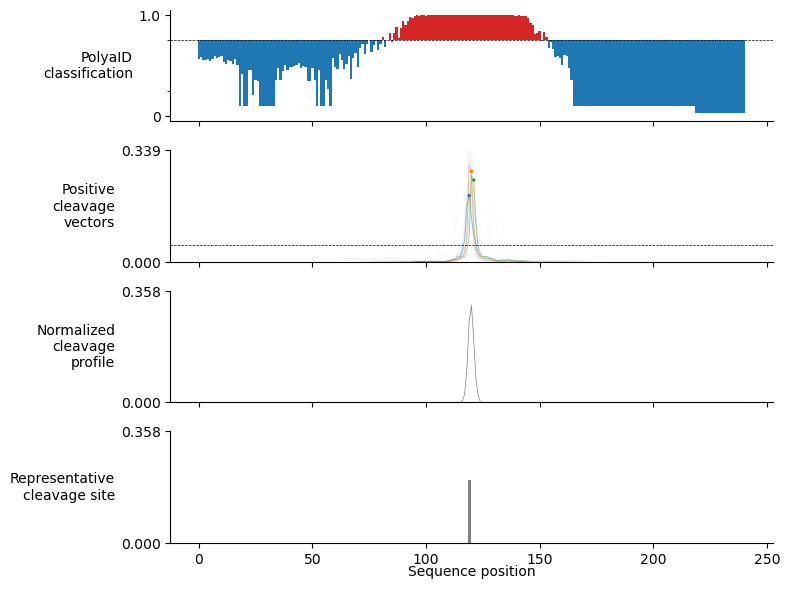

In [17]:
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True,
                         gridspec_kw={'height_ratios':[1,1,1,1]})

_ = cleavage_profile_explanation2(
    axes, region, inputs, reads_dict, genome,
    visible_region=(0, n), visible_labels='absolute',
    cutoff_class=0.75, cutoff_clv=0.05, normalize=True,
    ylims_3reads=(0,10), ylims_clv=None, ylims_pro=None,
)

axes[0].set_ylabel("PolyaID\nclassification",       rotation=0, ha='right', va='center')
axes[1].set_ylabel("Positive\ncleavage\nvectors",   rotation=0, ha='right', va='center')
axes[2].set_ylabel("Normalized\ncleavage\nprofile", rotation=0, ha='right', va='center')
axes[3].set_ylabel("Representative\ncleavage site", rotation=0, ha='right', va='center')
axes[3].set_xlabel("Sequence position", rotation=0, ha='center', va='center')

plt.tight_layout()
plt.savefig(OUTDIR / "cleavage_profile_explanation.human_example.svg", dpi=600, transparent=True)
plt.show()
